In [2]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np

import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from models import VGG16, ResNet18

from solvers import *
from experiments.utils import *

from scipy.linalg import eigh

/opt/mambaforge/envs/landing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def dataset_simulated_ica(n_samples = 10000, n_features = 10, batch_size=4*128, device = 'cpu', random_state=42):
    rng = np.random.RandomState(random_state)
    sources = rng.laplace(size=(n_samples, n_features))
    mixing = rng.randn(n_features, n_features)
    #X = np.dot(sources, mixing.T)
    #W = np.linalg.pinv(sqrtm(X.T.dot(X) / n_samples))
    X = np.dot(sources, mixing.T)
    #mixing = np.dot(W, mixing)
    X = torch.from_numpy(X).to(device=device)
    mixing = torch.from_numpy(mixing).to(device=device)
    dataset = torch.utils.data.TensorDataset(X)
    dataloader = torch.utils.data.DataLoader(dataset,
                        batch_size=batch_size, shuffle=False)
    return dict(dataloader=dataloader, mixing=mixing)

data = dataset_simulated_ica(device = 'cuda')
dataloader = data['dataloader']
mixing = data['mixing']

device = 'cuda'
p = 10

In [4]:
def sigma(x):
    return(torch.log(torch.cosh(x)))

def amari_distance(W, A):
    """
    Computes the Amari distance between two matrices W and A.
    It cancels when WA is a permutation and scale matrix.
    Parameters
    ----------
    W : ndarray, shape (n_features, n_features)
        Input matrix
    A : ndarray, shape (n_features, n_features)
        Input matrix
    Returns
    -------
    d : float
        The Amari distance
    """
    P = W @ A

    def s(r):
        val_max, _ = torch.max(r ** 2, axis=1)
        return torch.sum(torch.sum(r ** 2, axis=1) / val_max - 1)

    return (s(torch.abs(P)) + s(torch.abs(P.T))) / (2 * P.shape[0])

In [5]:
A_full = dataloader.dataset.tensors[0]
n_samples, n_features = dataloader.dataset.tensors[0].shape 
Id =  torch.eye(p,p, device = device)
AtA_full = A_full.T @ A_full / n_samples
objective = lambda x: torch.sum(sigma(A_full @ x).flatten()).item() / n_samples
distance = lambda x: torch.linalg.norm(x.T@AtA_full@x-Id).item()

In [6]:
# Initialize based on first batch

batch_init = iter(dataloader).__next__()
batch_init = batch_init[0].to(device)

x0,_ = torch.linalg.qr(torch.randn(n_features, p, device=device, dtype=float))
Ax0 = batch_init @ x0
R = torch.linalg.cholesky(Ax0.T @ Ax0 / batch_init.size(1));
x0 = torch.linalg.solve(R, x0.T).T

print(objective(x0))
print(distance(x0))
x = torch.nn.Parameter(x0).to(device)

learning_rate = 1e-2
omega=1
grad_type = 'precon'
regul_type = 'matrix'

#optimizerICA = LandingGeneralizedStiefel((x,), lr=learning_rate, omega=omega,grad_type=grad_type,regul_type=regul_type)
    
optimizerICA = RiemannianGeneralizedStiefel((x,), lr=learning_rate,eps_regul=1e-8) 

0.09889907425245087
3.098966139020586


In [11]:
n_epochs = 100
averaging = True
distances = []
obj_values = []
amari_distances = []
for epoch in range(n_epochs):
    iteration = 0
    if averaging and epoch == 0:
            n_samples_seen = 0
            AtA = torch.zeros_like(AtA_full, device=device)
    for ind, A_sample in enumerate(dataloader):
        A_sample = A_sample[0].to(device)
        n_batch =  A_sample.size(0)
        if averaging and epoch == 0:
                AtA = (AtA*n_samples_seen + A_sample.T@A_sample)/(n_samples_seen+n_batch)
                n_samples_seen = n_samples_seen + n_batch
        elif not averaging:
                AtA = A_sample.T@A_sample/n_batch
        if regul_type == 'matrix':
            #Ax = A_sample @ x
            objective_optim = (torch.sum(sigma(AtA@x)).flatten() / n_batch).to(device)
            optimizerICA.zero_grad()
            objective_optim.backward()
            optimizerICA.step(((AtA,),))
    amari_distances.append(amari_distance(mixing.T,x).item())
    obj_values.append(objective(x))
    distances.append(distance(x))

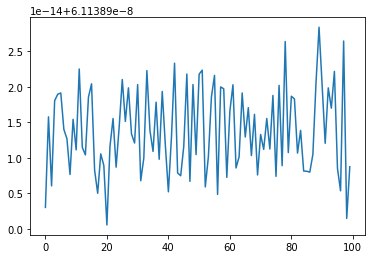

In [17]:
plt.plot(obj_values)